OrderedDict([('IL6', 9.999999999999993), ('PGE2', 56.25001273675189)])


/Users/matin/miniconda3/envs/v37_conda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/matin/miniconda3/envs/v37_conda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


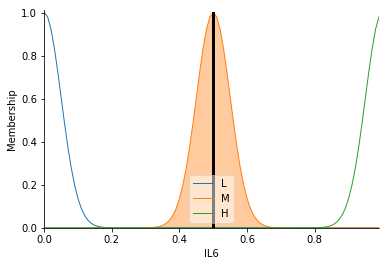

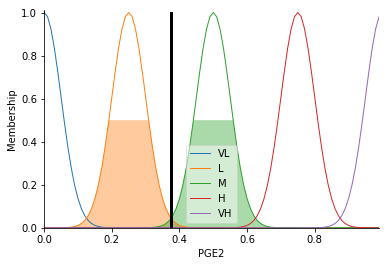

In [30]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
%config Completer.use_jedi = False
showOriginalModelString = True
#TODO: watch out that ctrl gets reset at each calibration run
free_params = {
    'TNF_a_l': 5
}
params = {
    'TNF_a': [0,free_params['TNF_a_l'],10],
    'IL10': [0,10],
    'IL6': [0,2], #ng/ml #TODO: adjust this based on the literature
    'PGE2': [0,0.2] #ng/ml  #TODO: adjust this based on the literature
}
class Controller:
    def __init__(self,params):
        self.antecedents = []
        self.consequents = []
        self.params = params
    def setup(self):
        TNF_a_0 = self.params['TNF_a'][0]; TNF_a_1 = self.params['TNF_a'][1]; TNF_a_end = self.params['TNF_a'][2] 
        IL10_0 = self.params['IL10'][0]; IL10_end = self.params['IL10'][-1]; 
        #// define antecedents
        TNF_a = ctrl.Antecedent(np.arange(TNF_a_0, TNF_a_end, .05), 'TNF_a')
        IL10 = ctrl.Antecedent(np.arange(IL10_0, IL10_end, .05), 'IL10')
        #// define memberships
        TNF_a['L'] = fuzz.trimf(TNF_a.universe, [TNF_a_0, TNF_a_0, TNF_a_1])
        TNF_a['M'] = fuzz.trimf(TNF_a.universe, [TNF_a_0, TNF_a_1, TNF_a_end])
        TNF_a['H'] = fuzz.trimf(TNF_a.universe, [TNF_a_1, TNF_a_end, TNF_a_end])

        IL10['L'] = fuzz.trimf(IL10.universe, [IL10_0, IL10_0, IL10_end])
        IL10['H'] = fuzz.trimf(IL10.universe, [IL10_0, IL10_end, IL10_end])
        #// store
        self.antecedents.append(TNF_a)
        self.antecedents.append(IL10)
#         IL10.view()
#         TNF_a.view()
        
        #// define consequents
        range_value = np.arange(0, 1, .01)
        IL6 = ctrl.Consequent(range_value, 'IL6')
        PGE2 = ctrl.Consequent(range_value, 'PGE2')
        
        #// define membershio functions
        sigma = .05
        intervals = [0,.5, 1]
        IL6['L']=fuzz.gaussmf(range_value, intervals[0], sigma)
        IL6['M']=fuzz.gaussmf(range_value, intervals[1], sigma)
        IL6['H']=fuzz.gaussmf(range_value, intervals[2], sigma)
#         IL6.automf(3)
        intervals = [0,.25,.5,.75, 1]
        PGE2['VL']=fuzz.gaussmf(range_value, intervals[0], sigma)
        PGE2['L']=fuzz.gaussmf(range_value, intervals[1], sigma)
        PGE2['M']=fuzz.gaussmf(range_value, intervals[2], sigma)
        PGE2['H']=fuzz.gaussmf(range_value, intervals[3], sigma)
        PGE2['VH']=fuzz.gaussmf(range_value, intervals[4], sigma)
#         PGE2.automf(5)
        
        #// Store
        self.consequents = [IL6,PGE2]
        #// rules
        TNF_rules = [
        ctrl.Rule(TNF_a['L'] , IL6['L']),
        ctrl.Rule(TNF_a['M'] , IL6['M']),
        ctrl.Rule(TNF_a['H'] , IL6['H'])
        ]
        
        PGE2_rules = [
        ctrl.Rule( TNF_a['L'] , PGE2['VL']),
        ctrl.Rule( TNF_a['M'] & IL10['L'] , PGE2['L']),
        ctrl.Rule( TNF_a['M'] & IL10['H'] , PGE2['M']),
        ctrl.Rule( TNF_a['H'] & IL10['L'] , PGE2['H']),
        ctrl.Rule( TNF_a['H'] & IL10['H'] , PGE2['VH'])
        ]
        
        rules = TNF_rules + PGE2_rules
        self.controler = ctrl.ControlSystemSimulation(ctrl.ControlSystem(rules))
        
    def forward(self,inputs):
        for key,value in inputs.items():
            self.controler.input[key] = value
        self.controler.compute()
        for item in self.consequents:
            item.view(sim=self.controler)
        return self.controler.output
class Fuzzy_MSC:
    def __init__(self,params):
        self.params = params
    def setup(self):
        self.controller = Controller(self.params)
        self.controller.setup()
    def forward(self,inputs):
        outputs = self.controller.forward(inputs)
        outputs['IL6'] *= (self.params['IL6'][-1]-self.params['IL6'][0])+self.params['IL6'][0]
        outputs['PGE2'] *= (self.params['PGE2'][-1]-self.params['PGE2'][0])+self.params['PGE2'][0]
        return outputs
        
obj = Fuzzy_MSC(params=params)
obj.setup()
inputs = {'TNF_a':5,'IL10':5}
print(obj.forward(inputs))